# Audio and video podcast generation with Azure AI services

<img src="podcast.jpg" width=600>

### Steps:
- Parsing a document with Azure Document Intelligence and generate a markdown output
- Analyse this output to generate a text podcast between two people using Azure OpenAI
- Use of some Azure HD voices with Azure Speech Services
- Export the generated audio file into a video file

## 0. Librairies

In [104]:
#%pip install azure-ai-documentintelligence
#%pip install azure-cognitiveservices-speech
#%pip install eyed3
#%pip install openai
#%pip install gradio===5.9.1
#%pip install lameenc
#%pip install tiktoken
#%pip install python-dotenv
#%pip install moviepy
#%pip install numpy==2.0

In [105]:
import azure.ai.documentintelligence
import azure.cognitiveservices.speech
import azure.cognitiveservices.speech as speechsdk
import contextlib
import eyed3
import io
import openai
import os
import json
import gradio as gr
import lameenc
import matplotlib.pyplot as plt
import numpy as np
import shutil
import sys
import tiktoken
import time
import wave

from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import AnalyzeDocumentRequest, DocumentContentFormat, DocumentAnalysisFeature, AnalyzeOutputOption
from azure.core.credentials import AzureKeyCredential
from datetime import datetime
from dotenv import load_dotenv
from IPython.display import Audio, FileLink, Markdown, Video, display, Image
from moviepy import ImageClip, AudioFileClip, CompositeAudioClip
from openai import AzureOpenAI

## 1. Settings

In [106]:
print(f"Python version: {sys.version}")

Python version: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]


In [107]:
print(f"Azure Document Intelligence version: {azure.ai.documentintelligence.__version__}")
print(f"Azure Speech services version: {azure.cognitiveservices.speech.__version__}")
print(f"Azure OpenAI version: {openai.__version__}")

Azure Document Intelligence version: 1.0.0
Azure Speech services version: 1.42.0
Azure OpenAI version: 1.59.6


In [108]:
today = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Today is {today}")

Today is 2025-01-16 13:48:18


In [109]:
load_dotenv("azure.env")

# Azure Document Intelligence
AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
AZURE_DOCUMENT_INTELLIGENCE_KEY = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_KEY")

# Azure OpenAI
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY")
AZURE_OPENAI_API_VERSION = "2024-10-21"
AZURE_OPENAI_MODEL = "gpt-4o-mini"  # Azure OpenAI model to use

# Azure AI Speech services
AZURE_SPEECH_KEY = os.getenv("AZURE_SPEECH_KEY")
AZURE_SPEECH_REGION = os.getenv("AZURE_SPEECH_REGION")

### Directories

In [110]:
DOCUMENTS_DIR = "documents"

In [111]:
AUDIO_DIR = "outputs/audio"

os.makedirs(AUDIO_DIR, exist_ok=True)

In [112]:
RESULTS_DIR = "outputs/results"

os.makedirs(RESULTS_DIR, exist_ok=True)

In [113]:
VIDEO_DIR = "outputs/video"

os.makedirs(VIDEO_DIR, exist_ok=True)

In [114]:
# Deletion of contents
delete_dir = True

if delete_dir:
    # Delete and recreate AUDIO_DIR
    shutil.rmtree(AUDIO_DIR)
    os.makedirs(AUDIO_DIR)
    # Delete and recreate RESULTS_DIR
    shutil.rmtree(RESULTS_DIR)
    os.makedirs(RESULTS_DIR)
    # Delete and recreate VIDEO_DIR
    shutil.rmtree(VIDEO_DIR)
    os.makedirs(VIDEO_DIR)

## 2. Functions

In [115]:
def azure_document_intelligence(input_file):
    """
    Analyzes a document using Azure Document Intelligence 1.0 and extracts its content in Markdown format.
    Note: requires V1.0 of Azure Document Intelligence python SDK.

    https://github.com/Azure/azure-sdk-for-python/blob/azure-ai-documentintelligence_1.0.0/sdk/documentintelligence/azure-ai    documentintelligence/CHANGELOG.md#100-2024-12-17
    
    This function reads a PDF file, sends it to Azure Document Intelligence for analysis 
    using the prebuilt layout model, and returns the extracted content in Markdown format along with 
    the number of pages in the document.

    Parameters:
    input_file (str): The path to the input PDF file.

    Returns:
    tuple: A tuple containing:
        - markdown (str): The extracted content in Markdown format.
        - nbpages (int): The number of pages in the document.
        - nb_tokens (int): Number of tokens
    """
    # Reading the file
    with open(input_file, "rb") as file:
        file_bytes = file.read()

    # Azure Document Intelligence client
    azure_docintell_client = DocumentIntelligenceClient(
            endpoint=AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT,
            credential=AzureKeyCredential(AZURE_DOCUMENT_INTELLIGENCE_KEY),
        )
    
    # Get results    
    document_request = AnalyzeDocumentRequest(bytes_source=file_bytes)
        
    poller = azure_docintell_client.begin_analyze_document(
        "prebuilt-layout",
        document_request,
        output=[AnalyzeOutputOption.FIGURES],  # To get text on images
        output_content_format=DocumentContentFormat.MARKDOWN,  # markdown export
    )
    result = poller.result()

    # Get markdown output, total number of pages & number of tokens
    markdown = result.content
    nb_pages = len(result.pages)
    nb_tokens = len(tiktoken.get_encoding("o200k_base").encode(markdown))
    
    return markdown, nb_pages, nb_tokens

In [116]:
def elapsed_time():
    """
    Computes elapsed time
    """
    minutes, seconds = divmod((time.time() - start), 60)
    print(f"Done in {minutes:.0f} minutes and {seconds:.0f} seconds\n")

In [117]:
def get_podcast_conversation(document: str, title: str = "AI in Action", voice_1: str = "Jenny",  voice_2: str = "Brian"):
    """
    Generates a podcast conversation based on the provided document using Azure OpenAI.

    This function uses Azure OpenAI to create a conversation between two voices based on the content of the provided document.
    The conversation is formatted as a JSON object. The conversation should be technical, precise and should mention some key insights from the document.

    Parameters:
    document (str): The content of the document to be used for generating the conversation.
    title (str, optional): The title of the podcast. Defaults to "AI in Action".
    voice_1 (str, optional): The name of the first voice in the conversation. Defaults to "Jenny".
    voice_2 (str, optional): The name of the second voice in the conversation. Defaults to "Brian".

    Returns:
    dict: A JSON object containing the generated conversation.
    """
    # Azure OpenAI client
    AOAI_client = AzureOpenAI(
            api_key=AZURE_OPENAI_KEY,
            api_version=AZURE_OPENAI_API_VERSION,
            azure_endpoint=AZURE_OPENAI_ENDPOINT,
        )

    # Get results
    results = AOAI_client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": AZURE_OPENAI_PROMPT.format(voice_1=voice_1, voice_2=voice_2),
            },
            {
                "role": "user",
                "content": f"<title>{title}</title><documents><document>{document}</document></documents>",
            },
        ],
        model=AZURE_OPENAI_MODEL,
        temperature=0.7,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        max_tokens=16384,
        stop=None,
        response_format={"type": "json_schema", "json_schema": JSON_SCHEMA},
    )

    # Transform conversation into a json format
    json_podcast = json.loads(results.choices[0].message.content)
    
    return json_podcast

In [118]:
def podcast_script_to_ssml(podcast) -> str:
    """
    Convert a podcast script to SSML (Speech Synthesis Markup Language).

    This function takes a podcast script in the form of a dictionary and converts it into an SSML string.
    The SSML string can be used for text-to-speech synthesis, allowing the podcast script to be read 
    aloud by different voices.

    Parameters:
    podcast (dict): A dictionary containing the podcast script. The dictionary should have a "script" key,
    which is a list of dictionaries.
    Each dictionary in the list should have "name" and "message" keys, where "name" corresponds to the speaker's name
    and "message" is the text to be spoken.

    Returns:
    str: An SSML string representing the podcast script, with each message wrapped in a <voice> tag corresponding to the speaker.
    """
    #  Use an Azure HD voice.
    AZURE_VOICES = {
        "Andrew": "en-US-Andrew2:DragonHDLatestNeural",
        "Aria": "en-US-Aria:DragonHDLatestNeural",
        "Ava": "en-US-Ava:DragonHDLatestNeural",
        "Brian": "en-US-Brian:DragonHDLatestNeural",
        "Davis": "en-US-Davis:DragonHDLatestNeural",
        "Emma": "en-US-Emma2:DragonHDLatestNeural",
        "Jenny": "en-US-Jenny:DragonHDLatestNeural",
        "Steffan": "en-US-Steffan:DragonHDLatestNeural",
        "Denise": "fr-FR-DeniseNeural",  # Not suitable for best performance as compared to DragonHD voices
        "Henri": "fr-FR-HenriNeural", # Not suitable for best performance as compared to DragonHD voices
        "Remy": "fr-FR-RemyMultilingualNeural",  # Not suitable for best performance as compared to DragonHD voices
        "Vivienne": "fr-FR-VivienneMultilingualNeural",  # Not suitable for best performance as compared to DragonHD voices
    }
    
    podcast_script = podcast["script"]
    ssml = "<speak version='1.0' xmlns='http://www.w3.org/2001/10/synthesis' xmlns:mstts='https://www.w3.org/2001/mstts' xml:lang='en-US'>"

    for item in podcast_script:
        message = (
            item["message"]
            .replace("&", "&amp;")
            .replace("<", "&lt;")
            .replace(">", "&gt;")
            .replace('"', "&quot;")
            .replace("'", "&apos;")
        )
        # Get the voices from the table
        ssml += f"<voice name='{AZURE_VOICES[item['name']]}'>{message}</voice>"

    ssml += "</speak>"
        
    return ssml

In [119]:
def convert_wav_to_mp3(wav_file, mp3_file):
    """
    Converts a WAV audio file to an MP3 file using the `lameenc` library.

    This function reads an uncompressed WAV file, extracts its audio data and metadata
    (such as sample rate, number of channels, and sample width), and then encodes the audio 
    into MP3 format with a specified bitrate and quality. The resulting MP3 file is written 
    to the specified output file.

    Args:
        wav_file (str): Path to the input WAV file.
        mp3_file (str): Path to the output MP3 file.
    """
    with wave.open(wav_file, 'rb') as wav:
        sample_rate = wav.getframerate()
        n_channels = wav.getnchannels()
        sample_width = wav.getsampwidth()
        frames = wav.readframes(wav.getnframes())
    
    encoder = lameenc.Encoder()
    encoder.set_bit_rate(128)
    encoder.set_in_sample_rate(sample_rate)   # Sample rate, e.g., 44100 or 48000
    encoder.set_channels(n_channels)
    encoder.set_quality(0)   # Best quality setting (highest quality)
    mp3_data = encoder.encode(frames)
    mp3_data += encoder.flush()
    
    with open(mp3_file, 'wb') as mp3:
        mp3.write(mp3_data)

In [120]:
def azure_text_to_speech(ssml, output_audio_file_wav):
    """
    Use Azure Speech Service to convert SSML (Speech Synthesis Markup Language) to an audio file.

    This function takes an SSML string as input and uses the Azure Speech Service to synthesize speech 
    from the SSML.
    The synthesized speech is returned as audio bytes in the Riff48Khz16BitMonoPcm format.

    Parameters:
    ssml (str): The SSML string to be converted to speech.

    Returns:
    bytes: The synthesized speech audio data in bytes.

    Raises:
    Exception: If the speech synthesis is canceled or an error occurs during the process.
    """
    # Azure AI Speech config
    speech_config = speechsdk.SpeechConfig(
        subscription=AZURE_SPEECH_KEY,
        region=AZURE_SPEECH_REGION,
    )
    audio_config = None  # enable in-memory audio stream

    speech_config.set_speech_synthesis_output_format(
        speechsdk.SpeechSynthesisOutputFormat.Riff48Khz16BitMonoPcm
    )

    # Creates a speech synthesizer using the Azure Speech Service.
    speech_synthesizer = speechsdk.SpeechSynthesizer(
        speech_config=speech_config, audio_config=audio_config
    )

    # Synthesizes the received text to speech.
    result = speech_synthesizer.speak_ssml_async(ssml).get()

    if result.reason == speechsdk.ResultReason.SynthesizingAudioCompleted:
        # Create a BytesIO object from the audio bytes
        audio_io = io.BytesIO(result.audio_data)
        # Save the .wav audio file
        with wave.open(output_audio_file_wav, "wb") as wav_file:
            wav_file.setnchannels(1)
            wav_file.setsampwidth(2)  # 16-bit audio (CD-quality, most common).
            wav_file.setframerate(44100)  # Frame rate (samples per second)
            wav_file.writeframes(audio_io.read())

        # Convert the .wav audio file into a .mp3 audio file format
        output_audio_file_mp3 = os.path.join(AUDIO_DIR, f"{os.path.splitext(os.path.basename(input_file))[0]}_podcast.mp3")
        convert_wav_to_mp3(output_audio_file_wav, output_audio_file_mp3)

        return output_audio_file_mp3

    elif result.reason == speechsdk.ResultReason.Canceled:
        cancellation_details = result.cancellation_details
        print(f"Speech synthesis canceled: {cancellation_details.reason}")

        if (
            cancellation_details.reason == speechsdk.CancellationReason.Error
            and cancellation_details.error_details
        ):
            print(f"Error details: {cancellation_details.error_details}")

        raise Exception(f"Error details: {cancellation_details.error_details}")

    raise Exception(f"Unknown exit reason: {result.reason}")

In [121]:
def get_audio_statistics(audio_file):
    """
    Displays statistical information about an audio file (MP3 format).

    This function extracts and prints various audio properties such as the file's duration, 
    bitrate, sample rate, and number of channels. It utilizes the `eyed3` library to read 
    the audio file and retrieve relevant data.

    Args:
        audio_file (str): The path to the audio file (MP3 format) for which statistics 
                          will be displayed.

    Output:
        Prints the following information to the console:
            - File name
            - Duration of the audio in seconds
            - Bitrate of the audio in kilobits per second (kbps)
            - Sample rate in Hertz (Hz)
            - Number of channels (mono or stereo)
    """
    # Load file
    audio = eyed3.load(audio_file)
    file_size_bytes = os.path.getsize(audio_file)
    file_size_mb = file_size_bytes / (1024 * 1024)
    duration = audio.info.time_secs
    minutes, seconds = divmod(duration, 60)
    samplerate = audio.info.sample_freq
    channels = audio.info.mode
    
    # Print properties
    print(f"File: {audio_file}")
    print(f"File size: {file_size_mb:.2f} MB")
    print(f"Duration: {duration:.3f} seconds = {int(minutes)} minutes and {seconds:.3f} seconds")
    print(f"Sample Rate: {samplerate} Hz")
    print(f"Channels: {channels}")

    return duration, samplerate, channels

In [122]:
def get_video_podcast():
    """
    Converts a podcast audio file into a video podcast by overlaying it with a static background image.

    Parameters:
    -----------
    podcast_audio_file : str
        Path to the input podcast audio file (e.g., in MP3 format).

    Returns:
    --------
    str
        File path to the generated video podcast file.
    """
    video_podcast_file_path = f"{VIDEO_DIR}/{os.path.splitext(os.path.basename(input_file))[0]}_podcast.mp4"

    # Backgroup video image
    image_clip = ImageClip("podcast.jpg")
    # Processing
    audio_clip = AudioFileClip(podcast_audio_file)
    video_clip = image_clip.with_duration(audio_clip.duration)
    new_audioclip = CompositeAudioClip([audio_clip])
    video_clip.audio = new_audioclip
    video_clip.write_videofile(video_podcast_file_path, fps=24, codec="libx264", audio_codec="aac")
    print("\nVideo generated successfully:", video_podcast_file_path)

    return video_podcast_file_path

## 3. Get markdown text from a file using Azure Document Intelligence

In [123]:
documents_list = [os.path.join(DOCUMENTS_DIR, filename) for filename in os.listdir(DOCUMENTS_DIR) 
                  if os.path.isfile(os.path.join(DOCUMENTS_DIR, filename)) and not filename.endswith('.checkpoints')]

documents_list

['documents/azure_openai_updates.pptx',
 'documents/genai-for-next-gen-governments.pdf',
 'documents/Introducing_Azure_AI_Agent_Service.pdf',
 'documents/msft.jpg']

In [124]:
input_file = documents_list[3]

!ls $input_file -lh

-rwxrwxrwx 1 root root 147K Jan 16 13:32 documents/msft.jpg


In [125]:
LINK = FileLink(path=input_file)

print("Click to download the file:")
LINK

Click to download the file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Azure AI Podcast/documents/msft.jpg

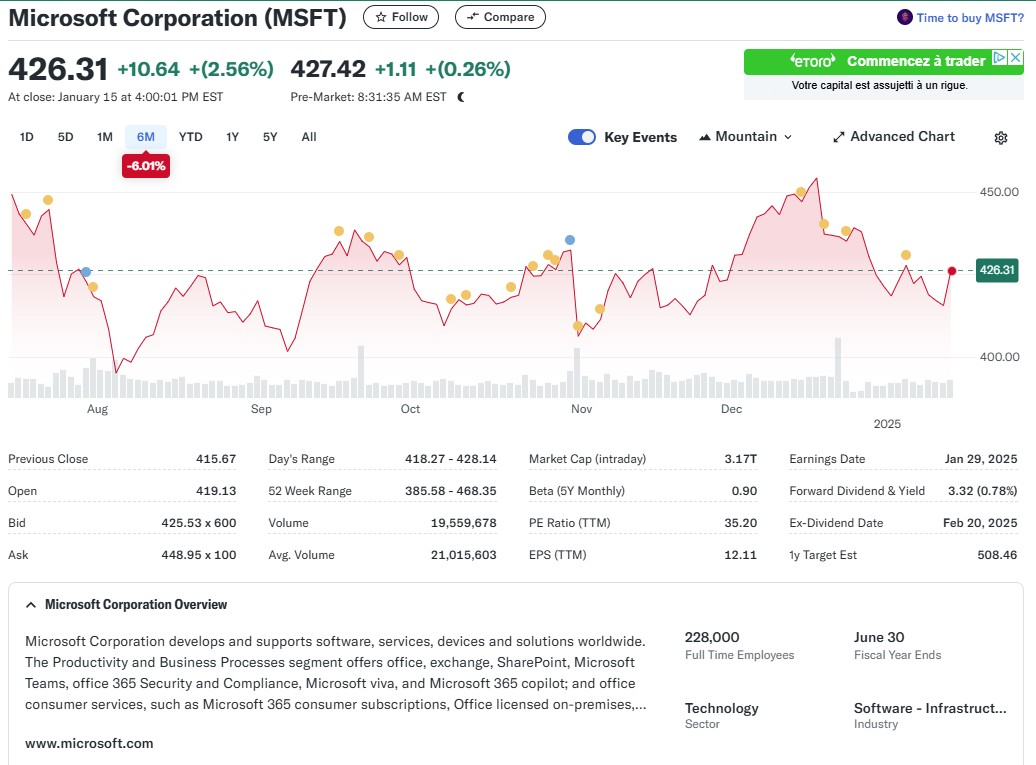

In [126]:
def is_image_file(file_path):
    image_extensions = ('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')
    return file_path.lower().endswith(image_extensions)

if is_image_file(input_file):
    display(Image(input_file))

In [127]:
start = time.time()

print(f"Get markdown transcript from the {input_file} using Azure Document Intelligence ...")
markdown_transcript, nb_pages, nb_tokens = azure_document_intelligence(input_file)

elapsed_time()

Get markdown transcript from the documents/msft.jpg using Azure Document Intelligence ...
Done in 0 minutes and 3 seconds



### Markdown text from the document (just displaying the first lines)

In [128]:
sample_markdown_for_viewing = "\n".join(markdown_transcript.splitlines()[:300])
Markdown(sample_markdown_for_viewing)

<!-- PageHeader="Microsoft Corporation (MSFT)" -->

\# Follow


<figure>

\+ Compare

</figure>


<figure>

Time to buy MSFT?

</figure>


426.31 +10.64 +(2.56%) 427.42 +1.11 +(0.26%)

At close: January 15 at 4:00:01 PM EST

Pre-Market: 8:31:35 AM EST

eToro Commencez a trader

Votre capital est assujetti à un rigue.


<figure>

1D

5D

1M

6M

YTD

1Y

5Y

All

Key Events

Mountain

Advanced Chart

-6.01%

450.00

426.31

400.00

Aug

Sep

Oct

Nov

Dec

2025

</figure>


<table>
<tr>
<th>Previous Close</th>
<th>415.67</th>
<th>Day's Range</th>
<th>418.27 - 428.14</th>
<th>Market Cap (intraday)</th>
<th>3.17T</th>
<th>Earnings Date</th>
<th>Jan 29, 2025</th>
</tr>
<tr>
<td>Open</td>
<td>419.13</td>
<td>52 Week Range</td>
<td>385.58 - 468.35</td>
<td>Beta (5Y Monthly)</td>
<td>0.90</td>
<td>Forward Dividend &amp; Yield</td>
<td>3.32 (0.78%)</td>
</tr>
<tr>
<td>Bid</td>
<td>425.53 × 600</td>
<td>Volume</td>
<td>19,559,678</td>
<td>PE Ratio (TTM)</td>
<td>35.20</td>
<td>Ex-Dividend Date</td>
<td>Feb 20, 2025</td>
</tr>
<tr>
<td>Ask</td>
<td>448.95 x 100</td>
<td>Avg. Volume</td>
<td>21,015,603</td>
<td>EPS (TTM)</td>
<td>12.11</td>
<td>1y Target Est</td>
<td>508.46</td>
</tr>
</table>


# ^ Microsoft Corporation Overview

Microsoft Corporation develops and supports software, services, devices and solutions worldwide.
The Productivity and Business Processes segment offers office, exchange, SharePoint, Microsoft
Teams, office 365 Security and Compliance, Microsoft viva, and Microsoft 365 copilot; and office
consumer services, such as Microsoft 365 consumer subscriptions, Office licensed on-premises, ...

228,000
Full Time Employees

June 30
Fiscal Year Ends

Technology
Sector

Software - Infrastruct ...
Industry

<!-- PageFooter="www.microsoft.com" -->

### Statistics

In [129]:
print(f"Total number of pages of the document = {nb_pages}")

Total number of pages of the document = 1


In [130]:
print(f"Total number of tokens of the document = {nb_tokens}")

Total number of tokens of the document = 607


In [131]:
markdown_file_path = f"{RESULTS_DIR}/{os.path.splitext(os.path.basename(input_file))[0]}_markdown.md"

with open(markdown_file_path, "w") as file:
    file.write(markdown_transcript)

print(f"Transcript markdown saved to {markdown_file_path}")

Transcript markdown saved to outputs/results/msft_markdown.md


## 4. Generate podcast discussion text with Azure OpenAI using GPT-4o

In [132]:
JSON_SCHEMA = {
    "name": "podcast",
    "strict": True,
    "description": "An AI generated podcast script.",
    "schema": {
        "type": "object",
        "properties": {
            "config": {
                "type": "object",
                "properties": {
                    "language": {
                        "type": "string",
                        "description": "Language code + locale (BCP-47), e.g. en-US or es-PA",
                    }
                },
                "required": ["language"],
                "additionalProperties": False,
            },
            "script": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "name": {
                            "type": "string",
                            "description": "Name of the host. Use the provided names, don't change the casing or name.",
                        },
                        "message": {"type": "string"},
                    },
                    "required": ["name", "message"],
                    "additionalProperties": False,
                },
            },
        },
        "required": ["config", "script"],
        "additionalProperties": False,
    },
}

In [133]:
AZURE_OPENAI_PROMPT = """
Craft an engaging podcast script featuring a conversation between two people based on the provided text. Use informal 
language to make the dialogue feel natural and human-like, including expressions like "wow," laughter, and pauses such as "uhm."

# Steps

1. **Review the Document(s) and Podcast Title**: Understand the main themes, key points, technical points, interesting facts, and overall tone.
2. **Adjust for Podcast Duration**: Generate a long conversation - output max_output_tokens tokens
3. **Character Development**: Create two distinct personalities for the hosts.
4. **Script Structure**: Balance detailed explanations with engaging dialogue
5. **Use Informal Language**: Incorporate expressions and fillers to create a natural flow in the dialogue.
6. **Add analysis, interpretations, or expert opinions based on the document.**: Address potential applications, challenges, or implications of the information. Include rhetorical questions, thought-provoking ideas, or challenges for the audience to reflect on. Suggest related topics for future exploration.
7. **Add Humor and Emotion**: Include laughter and emotional responses to make the conversation lively. Consider how the hosts would react to the content to keep it engaging.
8. **Summarize the key takeaways from the document**: End with a call to action or resources for further learning.
        
# Output Format

- A conversational podcast script in structured JSON.
- Include informal expressions and pauses.
- Clearly mark speaker turns.
- Name the hosts {voice_1} and {voice_2}.

# Examples

**Input:**
- Document: [Brief overview of the content, main themes, or key points]
- Podcast Title: "Exploring the Wonders of Space"

**Output:**
- Speaker 1: "Hey everyone, welcome to 'Exploring the Wonders of Space!' I'm [Name], and with me is [Name]."
- Speaker 2: "Hey! Uhm, I'm super excited about today's topic. Did you see the latest on the new satellite launch?"
- Speaker 1: "Wow, yes! It's incredible. I mean, imagine the data we'll get! [laughter]"
- (Continue with discussion, incorporating humor, informal, and technical language)

# Notes

- Balance informal language with technical communication.
- Generate the longest conversation you can do.
- Ensure the conversation is coherent and follows a logical progression.
- Adapt the style and tone based on the document's content and podcast title.
- Think step by step, grasp the key points of the document, and explain them in a conversational tone.
""".strip()

### Running the podcast text

In [134]:
voice1 = "Jenny"
voice2 = "Brian"

print(f"Speaker 1 Azure HD voice to use: {voice1}")
print(f"Speaker 2 Azure HD voice to use: {voice2}")

Speaker 1 Azure HD voice to use: Jenny
Speaker 2 Azure HD voice to use: Brian


In [135]:
start = time.time()

print(f"Get json podcast using voices of {voice1} and {voice2} using Azure OpenAI {AZURE_OPENAI_MODEL} model ...")
json_podcast = get_podcast_conversation(markdown_transcript, title = "Podcast genetation", voice_1 = voice1, voice_2 = voice2)

elapsed_time()

Get json podcast using voices of Jenny and Brian using Azure OpenAI gpt-4o-mini model ...
Done in 0 minutes and 7 seconds



In [136]:
json_podcast

{'config': {'language': 'en-US'},
 'script': [{'name': 'Jenny',
   'message': "Hey everyone! Welcome back to another episode of 'Market Buzz!' I'm Jenny."},
  {'name': 'Brian',
   'message': 'And I’m Brian! Uhm, today we’ve got some exciting stuff to chat about—Microsoft Corporation, or MSFT as the cool kids say.'},
  {'name': 'Jenny',
   'message': 'Haha, right?! So, Brian, did you catch the latest stock price? It’s sitting at 426.31 right now!'},
  {'name': 'Brian',
   'message': 'Wow, that’s a nice jump of over two and a half percent! I mean, what’s going on there? Is it time to buy?'},
  {'name': 'Jenny',
   'message': 'Yeah, totally! It’s like everyone’s been buzzing about it. Like, their market cap is over 3 trillion—no big deal.'},
  {'name': 'Brian',
   'message': 'Right? And did you see the earnings date coming up? January 29, 2025? That’s gonna be a big one.'},
  {'name': 'Jenny',
   'message': 'Oh for sure! And you know how it is with earnings reports. Everyone’s either hold

In [137]:
color_codes = {
    voice1: "\033[1;31;32m",  # Green
    voice2: "\033[1;31;34m"   # Blue
}

for item in json_podcast['script']:
    color = color_codes.get(item['name'], "")
    print(color + f"[{item['name']}] {item['message']}\n")

[Jenny] Hey everyone! Welcome back to another episode of 'Market Buzz!' I'm Jenny.

[Brian] And I’m Brian! Uhm, today we’ve got some exciting stuff to chat about—Microsoft Corporation, or MSFT as the cool kids say.

[Jenny] Haha, right?! So, Brian, did you catch the latest stock price? It’s sitting at 426.31 right now!

[Brian] Wow, that’s a nice jump of over two and a half percent! I mean, what’s going on there? Is it time to buy?

[Jenny] Yeah, totally! It’s like everyone’s been buzzing about it. Like, their market cap is over 3 trillion—no big deal.

[Brian] Right? And did you see the earnings date coming up? January 29, 2025? That’s gonna be a big one.

[Jenny] Oh for sure! And you know how it is with earnings reports. Everyone’s either holding their breath or biting their nails.

[Brian] Haha, exactly! I mean, what do you think? Do you think they’ll beat expectations this time?

[Jenny] Mmm, I mean, looking at their past performance, they usually do pretty well, right? Their PE ra

In [138]:
json_podcast_file_path = f"{RESULTS_DIR}/{os.path.splitext(os.path.basename(input_file))[0]}_json_podcast.json"

with open(json_podcast_file_path, "w") as json_file:
    json.dump(json_podcast, json_file, indent=4)

print(f"Json podcast saved to {json_podcast_file_path}")

Json podcast saved to outputs/results/msft_json_podcast.json


In [139]:
text_podcast_file_path = f"{RESULTS_DIR}/{os.path.splitext(os.path.basename(input_file))[0]}_text_podcast.txt"

podcast_text = []
for item in json_podcast['script']:
    podcast_text.append(f"[{item['name']}] {item['message']}\n\n")
podcast_text = ''.join(podcast_text)

with open(text_podcast_file_path, "w") as file:
    file.write(podcast_text)
print(f"Text podcast saved to {text_podcast_file_path}")

Text podcast saved to outputs/results/msft_text_podcast.txt


## 5. Convert podcast script to SSML

In [140]:
podcast_ssml = podcast_script_to_ssml(json_podcast)
podcast_ssml

"<speak version='1.0' xmlns='http://www.w3.org/2001/10/synthesis' xmlns:mstts='https://www.w3.org/2001/mstts' xml:lang='en-US'><voice name='en-US-Jenny:DragonHDLatestNeural'>Hey everyone! Welcome back to another episode of &apos;Market Buzz!&apos; I&apos;m Jenny.</voice><voice name='en-US-Brian:DragonHDLatestNeural'>And I’m Brian! Uhm, today we’ve got some exciting stuff to chat about—Microsoft Corporation, or MSFT as the cool kids say.</voice><voice name='en-US-Jenny:DragonHDLatestNeural'>Haha, right?! So, Brian, did you catch the latest stock price? It’s sitting at 426.31 right now!</voice><voice name='en-US-Brian:DragonHDLatestNeural'>Wow, that’s a nice jump of over two and a half percent! I mean, what’s going on there? Is it time to buy?</voice><voice name='en-US-Jenny:DragonHDLatestNeural'>Yeah, totally! It’s like everyone’s been buzzing about it. Like, their market cap is over 3 trillion—no big deal.</voice><voice name='en-US-Brian:DragonHDLatestNeural'>Right? And did you see the

In [141]:
ssml_file_path = f"{RESULTS_DIR}/{os.path.splitext(os.path.basename(input_file))[0]}_ssml_podcast.txt"

# Save the data to a JSON file
with open(ssml_file_path, "w") as json_file:
    json.dump(podcast_ssml, json_file, indent=4)

print(f"SSML file saved to {ssml_file_path}")

SSML file saved to outputs/results/msft_ssml_podcast.txt


## 6. Generation of the audio podcast file with Azure Speech Services

In [142]:
start = time.time()

output_mp3_file = f"{os.path.splitext(os.path.basename(input_file))[0]}_podcast.mp3"
podcast_audio_file = os.path.join(AUDIO_DIR, output_mp3_file)
print(f"Generation of the podcast audio file: {podcast_audio_file} using Azure Speech Services ...")

azure_text_to_speech(podcast_ssml, podcast_audio_file)

elapsed_time()

!ls $podcast_audio_file -lh

Generation of the podcast audio file: outputs/audio/msft_podcast.mp3 using Azure Speech Services ...
Done in 1 minutes and 49 seconds

-rwxrwxrwx 1 root root 2.9M Jan 16 13:50 outputs/audio/msft_podcast.mp3


In [143]:
print(f"Playing audio file: {podcast_audio_file}")
Audio(podcast_audio_file, autoplay=False)

Playing audio file: outputs/audio/msft_podcast.mp3


In [144]:
duration, samplerate, channels = get_audio_statistics(podcast_audio_file)

File: outputs/audio/msft_podcast.mp3
File size: 2.81 MB
Duration: 184.790 seconds = 3 minutes and 4.790 seconds
Sample Rate: 44100 Hz
Channels: Mono


In [145]:
LINK = FileLink(path=podcast_audio_file)

print("Click to download the file:")
LINK

Click to download the file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Azure AI Podcast/outputs/audio/msft_podcast.mp3

## 7. Generation of the video podcast file

In [146]:
start = time.time()
video_podcast_file_path = get_video_podcast()
elapsed_time()

MoviePy - Building video outputs/video/msft_podcast.mp4.
MoviePy - Writing audio in msft_podcastTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
MoviePy - Writing video outputs/video/msft_podcast.mp4



MoviePy - Done !
MoviePy - video ready outputs/video/msft_podcast.mp4

Video generated successfully: outputs/video/msft_podcast.mp4
Done in 0 minutes and 15 seconds



In [147]:
Video(video_podcast_file_path, width = 512, height = 480)

In [148]:
LINK = FileLink(path=video_podcast_file_path)

print("Click to download the file:")
LINK

Click to download the file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow2/code/Users/seretkow/Azure AI Podcast/outputs/video/msft_podcast.mp4

## 8. Webapp with Gradio

In [149]:
def all_in_one(input_file):
    """
    Generate a podcast from a given input file.

    This function performs the following steps:
    1. Extracts the content from the input PDF file using Azure Document Intelligence and 
    converts it to Markdown format.
    2. Generates a podcast conversation in JSON format based on the extracted content.
    3. Converts the podcast conversation to SSML (Speech Synthesis Markup Language).
    4. Synthesizes the SSML to an audio file using Azure Text-to-Speech.

    Parameters:
    input_file (str): The path to the input PDF file.

    Returns:
    str: The path to the generated podcast audio file.
    """
    # 1 Get transcript
    markdown_transcript, nb_pages, nb_tokens = azure_document_intelligence(input_file)
    
    # 2 Text podcast generation
    json_podcast = get_podcast_conversation(markdown_transcript, title = "Podcast genetation", voice_1 = voice1, voice_2 = voice2)
    podcast_text = []
    for item in json_podcast['script']:
        podcast_text.append(f"[{item['name']}] {item['message']}\n\n")
    podcast_text = ''.join(podcast_text)
    
    # 3 Audio podcast generation
    podcast_ssml = podcast_script_to_ssml(json_podcast)
    output_mp3_file = f"podcast_{os.path.splitext(os.path.basename(input_file))[0]}.mp3"
    podcast_audio_file = os.path.join(AUDIO_DIR, output_mp3_file)
    azure_text_to_speech(podcast_ssml, podcast_audio_file)
    
    return markdown_transcript, podcast_text, podcast_audio_file

In [150]:
def podcast_webapp_fn(file, mode_debug=False):
    """
    Processes an uploaded podcast file and returns its transcript in Markdown format, 
    associated JSON data, and the podcast audio file. Optionally, debug information 
    is printed if the mode_debug flag is set to True.

    Args:
        file (file-like object): The uploaded file, expected to contain a podcast. 
                                 It should have a .name attribute to access the file name.
        mode_debug (bool, optional): If True, debug information (transcript, JSON, audio file) 
                                      will be printed to the console. Defaults to False.

    Returns:
        tuple: A tuple containing:
            - markdown_transcript (str): The podcast transcript in Markdown format, 
                                          or an error message if processing fails.
            - json_podcast (dict or None): The podcast's associated JSON data, 
                                           or None if processing fails.
            - podcast_audio_file (file or None): The audio file of the podcast, 
                                                  or None if processing fails.
    if file is None:
        return "Please upload a file.", None, None
    """
    try:
        input_file_path = file.name  # Use the .name attribute directly
        markdown_transcript, json_podcast, podcast_audio_file = all_in_one(input_file_path)
        if mode_debug:
            print(markdown_transcript, "\n")
            print(json_podcast, "\n")
            print(podcast_audio_file)
        return markdown_transcript, json_podcast, podcast_audio_file
    
    except Exception as e:
        return str(e), None, None

In [151]:
with gr.Blocks() as podcast_webapp:
    gr.Markdown("""
    # Podcast generator using Azure AI
    Upload a document file to generate a multimedia podcast. The file can be a PowerPoint, Word, PDF or an image.
    This webapp is using Azure OpenAI, Azure Document Intelligence and Azure Speech Services.
    """)

    with gr.Row():
        file_input = gr.File(
            label="Upload your document to generate a podcast",
            file_types=[".pdf", ".jpg", ".jpeg", ".docx", ".pptx"],
            interactive=True
        )

    with gr.Row():
        submit_button = gr.Button("Generate your multimedia podcast", variant="primary")

    with gr.Row():
        markdown_output = gr.Markdown(
            label="Markdown transcript (Azure Document Intelligence)"
        )
        json_output = gr.Textbox(
            label="Podcast conversation (Azure OpenAI GPT-4o)",
            lines=60,
            placeholder="Your podcast conversation will appear here"
        )

    with gr.Row():
        audio_output = gr.Audio(
            label="Generated audio podcast",
            type="filepath",
            interactive=True,
            elem_id="audio_player"
        )

    gr.Examples(
        examples=documents_list,
        inputs=file_input,
        label="Examples"
    )

    # Trigger function on button click
    submit_button.click(
        podcast_webapp_fn, 
        inputs=file_input, 
        outputs=[markdown_output, json_output, audio_output]
    )

In [152]:
# Launch the webapp
podcast_webapp.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://8cf362f135497605ef.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
